# k-Nearest Neighbors Model
kNN makes predictions based on its similarity to its neighbors or datapoints. We're using this model because:
* kNN is easier to implement compared to the rest of the models. We would like to see how a simpler model fares against more complex models. It can serve as a baseline.
* Our target variable has multiple categories. It may be naive but it works well for multiclass classification due to the majority vote.

It's important to note the following about kNN:
* It may struggle in highly-dimensional datasets and large datasets.
* After cleaning the dataset, there are notable imbalances according to the YData-Profiling Report. kNN may not be as accurate.

## Prerequisites

In [38]:
# necessary imports
import random
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# loading
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# for model
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import cross_val_predict, cross_val_score # don't need this, GridSearch performs it internally
from sklearn.preprocessing import LabelEncoder

# PCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [39]:
# setup code taken from STINTSY class notebook
# Makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Identifying Features to Consider

First, we will consider what variables to consider. (Feature Selection)

In [40]:
numerical_vars = ['PUFC25_PBASIC', 'PUFC05_AGE', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC28_THOURS'] # based on anova results
bincateg_vars = ['PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC20_PWMORE', 'PUFC22_PFWRK'] # by relevance
categ_vars = ['PUFC43_QKB', 'PUFC16_PKB', 'PUFC04_SEX', 'PUFC23_PCLASS', 'PUFURB2K10'] # by highest cramers v

# merge these into one
features = numerical_vars + bincateg_vars + categ_vars
print(features)

['PUFC25_PBASIC', 'PUFC05_AGE', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC28_THOURS', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC20_PWMORE', 'PUFC22_PFWRK', 'PUFC43_QKB', 'PUFC16_PKB', 'PUFC04_SEX', 'PUFC23_PCLASS', 'PUFURB2K10']


## Loading the Dataset
Then, we'll load the exported dataset into the environment.

In [41]:
# load dataset into the environment
file_dir = './cleaned_df.csv'

def load_dataset(filename):
    df = pd.read_csv('cleaned_df.csv') # read
    knn_df = df.copy() # make a copy
    return knn_df

knn_df = load_dataset(file_dir)
# knn_df.head(10)

## Encoding into Numerical Values
kNN requires numerical values for the features and target variable. We will encode the categorical variables into numerical values. This is done using the `LabelEncoder` class from the `sklearn.preprocessing` module. The `LabelEncoder` class is used to convert categorical labels into numerical values. It assigns a unique integer to each category in the dataset.

In [42]:
# knn expects everything to be in numeical format

label_encoder = LabelEncoder()
for col in bincateg_vars:
    knn_df[col] = label_encoder.fit_transform(knn_df[col])

# Encoding multiclass categorical variables
for col in categ_vars:
    knn_df[col] = label_encoder.fit_transform(knn_df[col])

features = numerical_vars + bincateg_vars + categ_vars

print(knn_df[features].values)
print(knn_df['PUFC14_PROCC'].values)

[[ 0.         49.          8.         ...  1.          4.
   0.        ]
 [ 0.         61.          4.         ...  0.          6.
   0.        ]
 [ 5.52545294 19.          8.         ...  1.          2.
   0.        ]
 ...
 [ 0.         32.          4.         ...  0.          4.
   0.        ]
 [ 0.         29.          8.         ...  1.          0.
   0.        ]
 [ 0.         18.          4.         ...  1.          4.
   0.        ]]
['Skilled Agricultural, Forestry and Fishery Workers'
 'Elementary Occupations' 'Elementary Occupations' ...
 'Skilled Agricultural, Forestry and Fishery Workers' 'Managers'
 'Managers']


## Splitting the Dataset into Training and Testing Sets
We will split the dataset into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance. We will use the `train_test_split` function from the `sklearn.model_selection` module to split the dataset. The function takes the features and target variable as input and returns the training and testing sets.

We set X to the set of of all feature columns and y to the column containing the target variable. Then we'll use `train_test_split` to split the dataset into training and test sets. The test size is set to 0.2, meaning that 20% of the data will be used for testing and 80% for training. The random state is set to 42 to ensure reproducibility. The

In [43]:
X = knn_df[features]
y = knn_df['PUFC14_PROCC']

knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

Let's select our features and our target. Let's also view the shape so that we can tell if the data was prepared correctly.

In [44]:
print('Training data shape: ', knn_X_train.shape)
print('Training labels shape: ', knn_y_train.shape)

print('Test data shape: ', knn_X_test.shape)
print('Test labels shape: ', knn_y_test.shape)

Training data shape:  (56968, 14)
Training labels shape:  (56968,)
Test data shape:  (14242, 14)
Test labels shape:  (14242,)


## Instantiating the Model and Initial Training
We will use the `KNeighborsClassifier` class from the `sklearn.neighbors` module to create the kNN model. The class takes several parameters, including the number of neighbors to consider (k) and the distance metric to use. 

We will set k to 5 arbitrarily and use the default distance metric (Euclidean distance).

In [45]:
n_neighbors = 5 # arbitrarily chosen

knn_model = KNeighborsClassifier(n_neighbors, algorithm='kd_tree', metric='euclidean')

knn_model.fit(knn_X_train, knn_y_train) # training the model

y_predicted = knn_model.predict(knn_X_test)

In [46]:
accuracy = accuracy_score(knn_y_test, y_predicted) # from sklearn
print(f"{round(accuracy * 100, 3)}% accuracy")

65.265% accuracy


In [47]:
classification_report = classification_report(knn_y_test, y_predicted)
print(classification_report)

                                                    precision    recall  f1-score   support

                          Armed Forces Occupations       0.06      0.06      0.06        16
                          Clerical Support Workers       0.39      0.46      0.42       625
                  Craft and Related Trades Workers       0.46      0.47      0.46       867
                            Elementary Occupations       0.73      0.74      0.73      4317
                                          Managers       0.61      0.54      0.57      1100
        Plant and Machine Operators and Assemblers       0.51      0.54      0.53       432
                                     Professionals       0.68      0.75      0.71      2024
                         Service and Sales Workers       0.54      0.45      0.49      1944
Skilled Agricultural, Forestry and Fishery Workers       0.79      0.89      0.84      2353
           Technicians and Associate Professionals       0.35      0.14      0.

Observations: Our initial model training shows that the model had an accuracy score of `65.27%`. It appears to be **undefitting**.
* Precision, F1-score, and recall are all low for `Armed Forces Occupations` and `Technicians and Associate Professionals`. It's struggling to capture the patterns in the data for these classes.
* The macro average F1-score is `0.50`, which indicates that the model is not performing well overall for all classes, especially those that are underrepresented. 
* The weighted average F1-score is `0.65`, this is close to the accuracy of `65.27%`. This indicates that the model is performing better on the majority classes than on the minority classes.
* By looking at the support column, There's a high class imbalance. For example, `Armed Forces Occupations` has a support of 16 samples while `Elementary Occupations` has 4317 samples.

To improve the model, let's try hyperparameter tuning to find the best value of k. We'll use GridSearchCV to find the best hyperparameters.

### Cross Validation and Hyperparameter Tuning
Cross Validation is a technique to evaluate the performance of our kNN model. It splits the dataset into k subsets called folds, and trained on k-1 folds. This is done to reduce overfitting in the model. [Source](https://www.statology.org/complete-guide-cross-validation/)

In kNN, we have a hyperparameter k (different from k-folds) which is used to determine how many neighbors are considered. For this example, we will use Grid Search to find the optimal parameters. Grid Search has a fit and score method. [Source](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

We are working with a very large dataset, so we will also be using Principal Component Analysis (PCA) to reduce the dimensionality before putting it through the Grid Search. [Source](https://peerdh.com/blogs/programming-insights/optimizing-k-nearest-neighbors-for-large-datasets-in-scikit-learn) We're only doing this once because doing it multiple times will be very expensive and time consuming.

Here, we use StandardScaler because kNN is sensitive to the scale of the data. StandardScaler standardizes the features by removing the mean and scaling to unit variance, which is important because kNN uses distance metrics to determine the similarity between data points, and if the features are not on the same scale, it can lead to biased results.

Let's see what the feature distribution looks like before scaling.

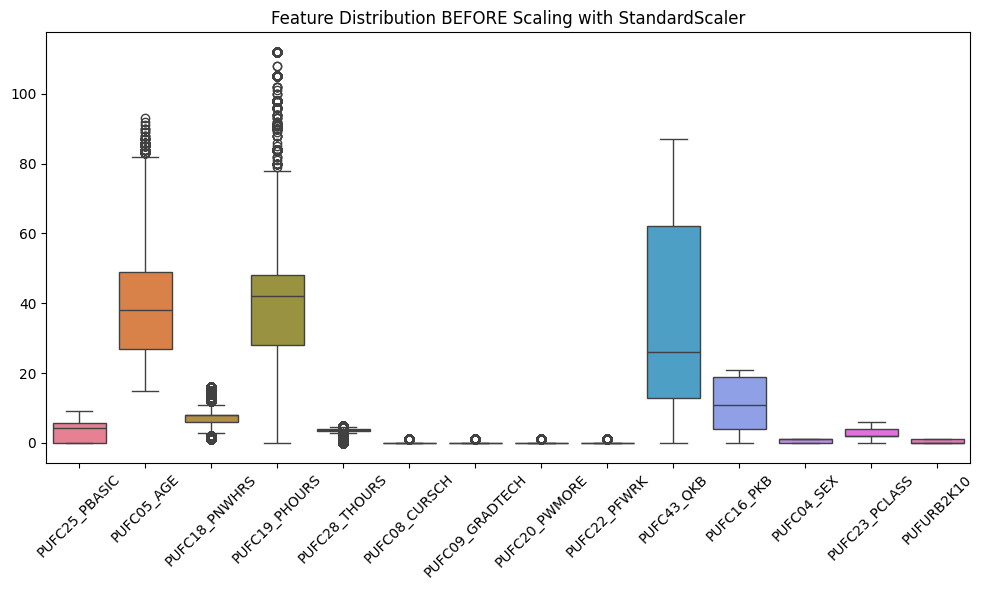

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(knn_X_train))
plt.title('Feature Distribution BEFORE Scaling with StandardScaler')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The boxplot looks very imbalanced. So let's use `StandardScaler()` and see what that looks like.

In [49]:
stdscaler = StandardScaler()
X_scaled = stdscaler.fit_transform(knn_X_train)

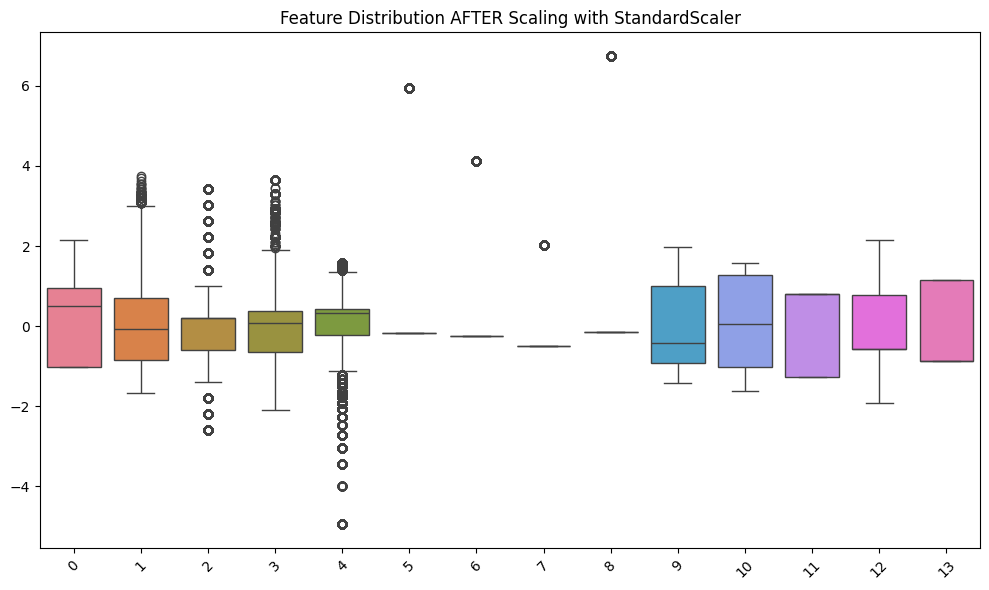

In [50]:
# before PCA after scaling
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(X_scaled))
plt.title('Feature Distribution AFTER Scaling with StandardScaler')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations:** Many features still have outliers, but the distribution is more normal than before scaling. The features are now on the same scale, which is important for PCA and KNN.

Then, we instantiate a PCA object and fit it to the training data. We will use the `fit_transform` method to transform the training data into a lower-dimensional space. The transformed data will be used to train the kNN model. We will also use the `transform` method to transform the testing data into the same lower-dimensional space.

Specifically, `pca.fit_transform()` does two steps: 
* `fit` computes the principal components of the input data `X_scaled`. It identifies the directions/principal components in the data that capture the maximum variance.
* `transform` projects the original data X_scaled onto the principal components to reduce the dimensionality of the data while retaining as much variance as possible.

In [51]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_scaled)

Let's check the explained variance ratio. Its used to understand how much of the total variance in the dataset is captured by each principal component. It's important to know because:
* Feature Selection: It helps us determine how many principal components to keep in the Feature Selection in order to retain most of the variance. 
* Dimensionality Reduction: Analyszing the cumulative variance ratio can help us decide the optimal number of components to keep while balancing the trade-off between dimensionality reduction and information retention.
* Noise Reduction: Components with low explained variance respond to noise or irrelevant features. Excluding these can help improve the performance. 

In [52]:
explained_variance_ratio = X_pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
for i, var in enumerate(cumulative_variance_ratio):
    print(f"Components {i+1}: {var:.3f} variance explained")

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

We set a threshold of `0.95`, meaning we want to keep enough components to explain 95% of the variance in the data.

In [ ]:
threshold = 0.95
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
print(f"Number of components to retain {threshold*100}% variance: {num_components}")

Number of components to retain 95.0% variance: 12


<span style="background-color: red">TODO if i'm doing PCA correctly cos what's the point of the X_pac</span>

Out of curiosity, let's see what the explained variance ratio of the PCA components looks like when plotted. 

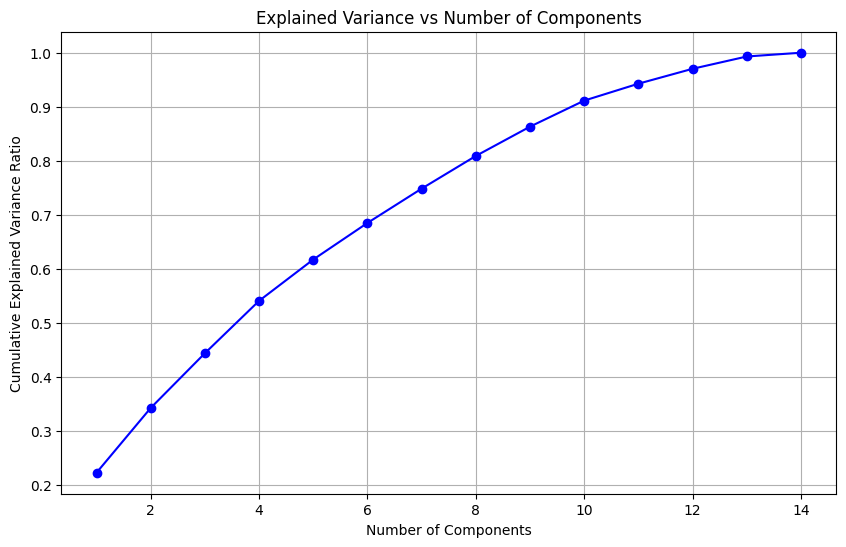

In [ ]:
# after PCA
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

**Observations:** 0.90 to 0.95 is a common threshold to keep. [Source](https://medium.com/@riya190304/finding-optimal-number-of-components-in-pca-2141d2891bed) We will use 0.95 as the threshold for PCA. This means we will keep enough components to explain 95% of the variance in the data. We will use the `n_components` parameter in the PCA class to set this threshold.

When we checked `num_components` awhile ago, it said we would need 12 components to retain 95% of the variance.

In [ ]:
pipeline = Pipeline([
    ('pca', PCA(n_components=12)), # keep 95% of variance
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9], # k values to try
    'knn__weights': ['uniform', 'distance'], # weighting options
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev'], # distance metrics to try
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] # different algorithms to try
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, # cross validation folds 
    verbose=1, # prints progress
    scoring='accuracy', # uses accuracy as a scoring metric
    n_jobs=-1 # use all the available cores
    )

grid_search.fit(knn_X_train, knn_y_train) # train the model

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\gicac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.64046482 0.64046482 0.65248903 0.65420936 0.65821158 0.66056385
 0.65994938 0.661266   0.65717587 0.66109046 0.65183962 0.65183962
 0.67063955 0.6681821  0.68066274 0.6777313  0.68171596 0.67982022
 0.68036433 0.68076815 0.62477179 0.62477179 0.62819464 0.63347844
 0.63332032 0.64049989 0.62984472 0.63951687 0.62591272 0.63711203
 0.64053503 0.64053503 0.65233105 0.65406893 0.6580887  0.66052874
 0.6600898  0.66135376 0.65736896 0.6610378  0.65190984 0.65190984
 0.6708502  0.66832253 0.68053988 0.67767865 0.68190905 0.67987289
 0.6806803  0.68076815 0.6248069  0.6248069  0.62810688 0.63335556
 0.63314479 0.64042968 0.63005536 0.6396222  0.62619356 0.63728757
 0.64046482 0.64046482 0.65248903 0.65420936 0.65821158 0.66056385
 0.65994938 0.661266   0.65717587 0.66109046 0.65183962 0.65183962
 0.67063955 0.6681821 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=12)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': [1, 3, 5, 7, 9],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [ ]:
print("GRID SEARCH best parameters: ", grid_search.best_params_)
print()
print("GRID SEARCH best score (accuracy): ", round(grid_search.best_score_, 3)) # prints the best score from the grid search

GRID SEARCH best parameters:  {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}

GRID SEARCH best score:  0.682


Observations: By doing PCA (considering 12 principal components) and GridSearch, we found that the optimal parameters are:
* knn_algorithm: ball_tree
* knn_metric: manhattan
* knn_n_neighbors: 7
* knn_weights: uniform

with a best accuracy score of 0.682 or 68.2%.